# Import libraries

In [1]:
import json
import os
import pprint
import numpy as np
import matplotlib.pyplot as plt

# Example of data format for a single scan's MRIQC output

In [2]:
filepath = "./json_results/sub-1000173_ses-NAPBL00_run-001_T1w.json"

with open(filepath, "r+") as file:
    data = json.load(file)
    del data['bids_meta']
    del data['provenance']
    pprint.pprint(data)

{'cjv': 0.505419840662851,
 'cnr': 2.608381362441234,
 'efc': 0.6700414046226537,
 'fber': 65.83421325683594,
 'fwhm_avg': 3.130486666666666,
 'fwhm_x': 3.22958,
 'fwhm_y': 3.21713,
 'fwhm_z': 2.94475,
 'icvs_csf': 0.2197020056438308,
 'icvs_gm': 0.3968994095766471,
 'icvs_wm': 0.3833985847795221,
 'inu_med': 1.3771222829818726,
 'inu_range': 0.44646955132484445,
 'qi_1': 0.0,
 'qi_2': 0.004732829912338535,
 'rpve_csf': 24.112069062368693,
 'rpve_gm': 13.161960052867572,
 'rpve_wm': 16.601523898483062,
 'size_x': 176,
 'size_y': 240,
 'size_z': 256,
 'snr_csf': 2.7699712491554163,
 'snr_gm': 8.563957777069179,
 'snr_total': 8.73997848255342,
 'snr_wm': 14.88600642143567,
 'snrd_csf': 8.045218245328096,
 'snrd_gm': 19.21383533791636,
 'snrd_total': 18.115955143524342,
 'snrd_wm': 27.08881184732856,
 'spacing_x': 1.0,
 'spacing_y': 1.0,
 'spacing_z': 1.0,
 'summary_bg_k': 1518.5623362872516,
 'summary_bg_mad': 24.185107048374242,
 'summary_bg_mean': 81.34371185302734,
 'summary_bg_median

# Function to find discrepancies in NeuroCI's output file

In [3]:
NeuroCI_results_file = "volumes_full.json"

#Find a discrepancy between FSL and FreeSurfer hippocampal volumes for a given scan
def find_discrepancy(json_results, filename):
    with open(json_results, "r+") as file:
        data = json.load(file)
        output = {}

        FSL = float(data[filename]['FSL'])
        FreeSurfer = float(data[filename]['FreeSurfer'])
        ASHS = float(data[filename]['ASHS'])

        output['FSL-FreeSurfer'] = abs(FSL-FreeSurfer)
        output['FSL-ASHS'] = abs(FSL-ASHS)
        output['ASHS-FreeSurfer'] = abs(ASHS-FreeSurfer)
        output['avg'] = (output['FSL-FreeSurfer'] + output['FSL-ASHS'] + output['ASHS-FreeSurfer']) / 3

        return output

#Example using the fn
find_discrepancy(NeuroCI_results_file, "sub-6852929_ses-NAPFU12_run-001_T1w.nii.gz")

{'FSL-FreeSurfer': 4142.1,
 'FSL-ASHS': 3322.0,
 'ASHS-FreeSurfer': 820.1000000000004,
 'avg': 2761.4}

# Making a list of all such dictionaries available in the 'mriqc_output' directory

In [4]:
mriqc_output_directory = "./json_results"
NeuroCI_results_file = "volumes_full.json"
list_of_mriqc = []
list_of_err = []

for filename in os.listdir(mriqc_output_directory):
    file_path = os.path.join(mriqc_output_directory, filename)
    with open(file_path, "r+") as file:
        data = json.load(file)
        del data['bids_meta']
        del data['provenance']
        data['filename'] = filename[:-5] + ".nii.gz" #Note that I added this so we know which result is of which scan.
        try:
            data['discrepancy'] = find_discrepancy(NeuroCI_results_file, data['filename']) #This is also added by me!
            list_of_mriqc.append(data)
        except:
            list_of_err.append(data['filename'])
        
print(str(len(list_of_mriqc)) + ' subjects were successful and ' + str(len(list_of_err)) + ' subjects had missing data.')
pprint.pprint(list_of_mriqc[2]) #each element of the list is the dictionary of a single MRIQC result file.

722 subjects were successful and 550 subjects had missing data.
{'cjv': 0.4589474686328697,
 'cnr': 2.8183498405824587,
 'discrepancy': {'ASHS-FreeSurfer': 620.0500000000002,
                 'FSL-ASHS': 2690.25,
                 'FSL-FreeSurfer': 3310.3,
                 'avg': 2206.866666666667},
 'efc': 0.6282549718822019,
 'fber': 100.4571304321289,
 'filename': 'sub-6852929_ses-NAPBL00_run-001_T1w.nii.gz',
 'fwhm_avg': 3.224016666666666,
 'fwhm_x': 3.27621,
 'fwhm_y': 3.36942,
 'fwhm_z': 3.02642,
 'icvs_csf': 0.1974390172618788,
 'icvs_gm': 0.40607015788550493,
 'icvs_wm': 0.3964908248526163,
 'inu_med': 1.3579199314117432,
 'inu_range': 0.4501024782657621,
 'qi_1': 5.676655793768357e-05,
 'qi_2': 0.004451045881323329,
 'rpve_csf': 27.42469795639944,
 'rpve_gm': 13.93006687098379,
 'rpve_wm': 17.52489472259281,
 'size_x': 176,
 'size_y': 240,
 'size_z': 256,
 'snr_csf': 3.2680442880744103,
 'snr_gm': 9.337978980269877,
 'snr_total': 10.161546058389943,
 'snr_wm': 17.87861490682554

# List of all MRIQC features names

In [5]:
keys_not_to_include = ['discrepancy', 'filename']

features_list = [key for key in list_of_mriqc[0] if (not key in keys_not_to_include)]

print(str(len(features_list))+ ' MRIQC features found.')

68 MRIQC features found.


# creating observations and target arrays

Exclude outliers

In [6]:
outliers = []
new_list_of_mriqc = []
for data in list_of_mriqc:
    if data['discrepancy']['FSL-FreeSurfer']>5000 or data['discrepancy']['FSL-ASHS']>10000 or data['discrepancy']['ASHS-FreeSurfer']>10000:
        outliers.append(data['filename'])
        continue
    new_list_of_mriqc.append(data)

list_of_mriqc = new_list_of_mriqc

print(str(len(outliers))+' outliers found.')

2 outliers found.


Create observations and target variables

In [7]:
observations = list()
for data in list_of_mriqc:
    x = list()
    for feature in features_list:
        x.append(data[feature])
    observations.append(np.array(x))
observations = np.array(observations)

target = {}
for discrepancy_key in data['discrepancy']:
    y = list()
    for data in list_of_mriqc:
        y.append(data['discrepancy'][discrepancy_key])
    target[discrepancy_key] = np.array(y)

removing bad features

In [8]:
# finding bad features
for i, feature in enumerate(features_list):
    if np.nan_to_num(np.std(observations[:,i]))==0:
        keys_not_to_include.append(feature)

    if np.sum(observations[:,i])==0:
        keys_not_to_include.append(feature)

# removing bad features from observations matrix
new_observations = list()
for i, feature in enumerate(features_list):
    if not feature in keys_not_to_include:
        new_observations.append(observations[:, i])
new_observations = np.array(new_observations).T
observations = new_observations

# removing bad features from features_list
for key in keys_not_to_include:
    if key in features_list:
        features_list.remove(key)


# finding top positively correlated features

finding the most correlated feature using the avg discrepency values

In [9]:
discrepancy_key = 'avg'

corr_list = list()
for i, feature in enumerate(features_list):
    corr_list.append(np.abs(np.corrcoef(target[discrepancy_key], observations[:, i])[0,1]))
corr_list = np.array(corr_list)
I = np.argmax(corr_list)
top_feature = features_list[I]
top_corr = corr_list[I]

print('top feature is "'+top_feature+'" with correlation of %.2f' %top_corr)

top feature is "efc" with correlation of 0.23


*** correlation of the top feature -efc- with FSL-FreeSurfer discrepancy = 0.24
*** correlation of the top feature -efc- with FSL-ASHS discrepancy = 0.22
*** correlation of the top feature -efc- with ASHS-FreeSurfer discrepancy = -0.04
*** correlation of the top feature -efc- with avg discrepancy = 0.23


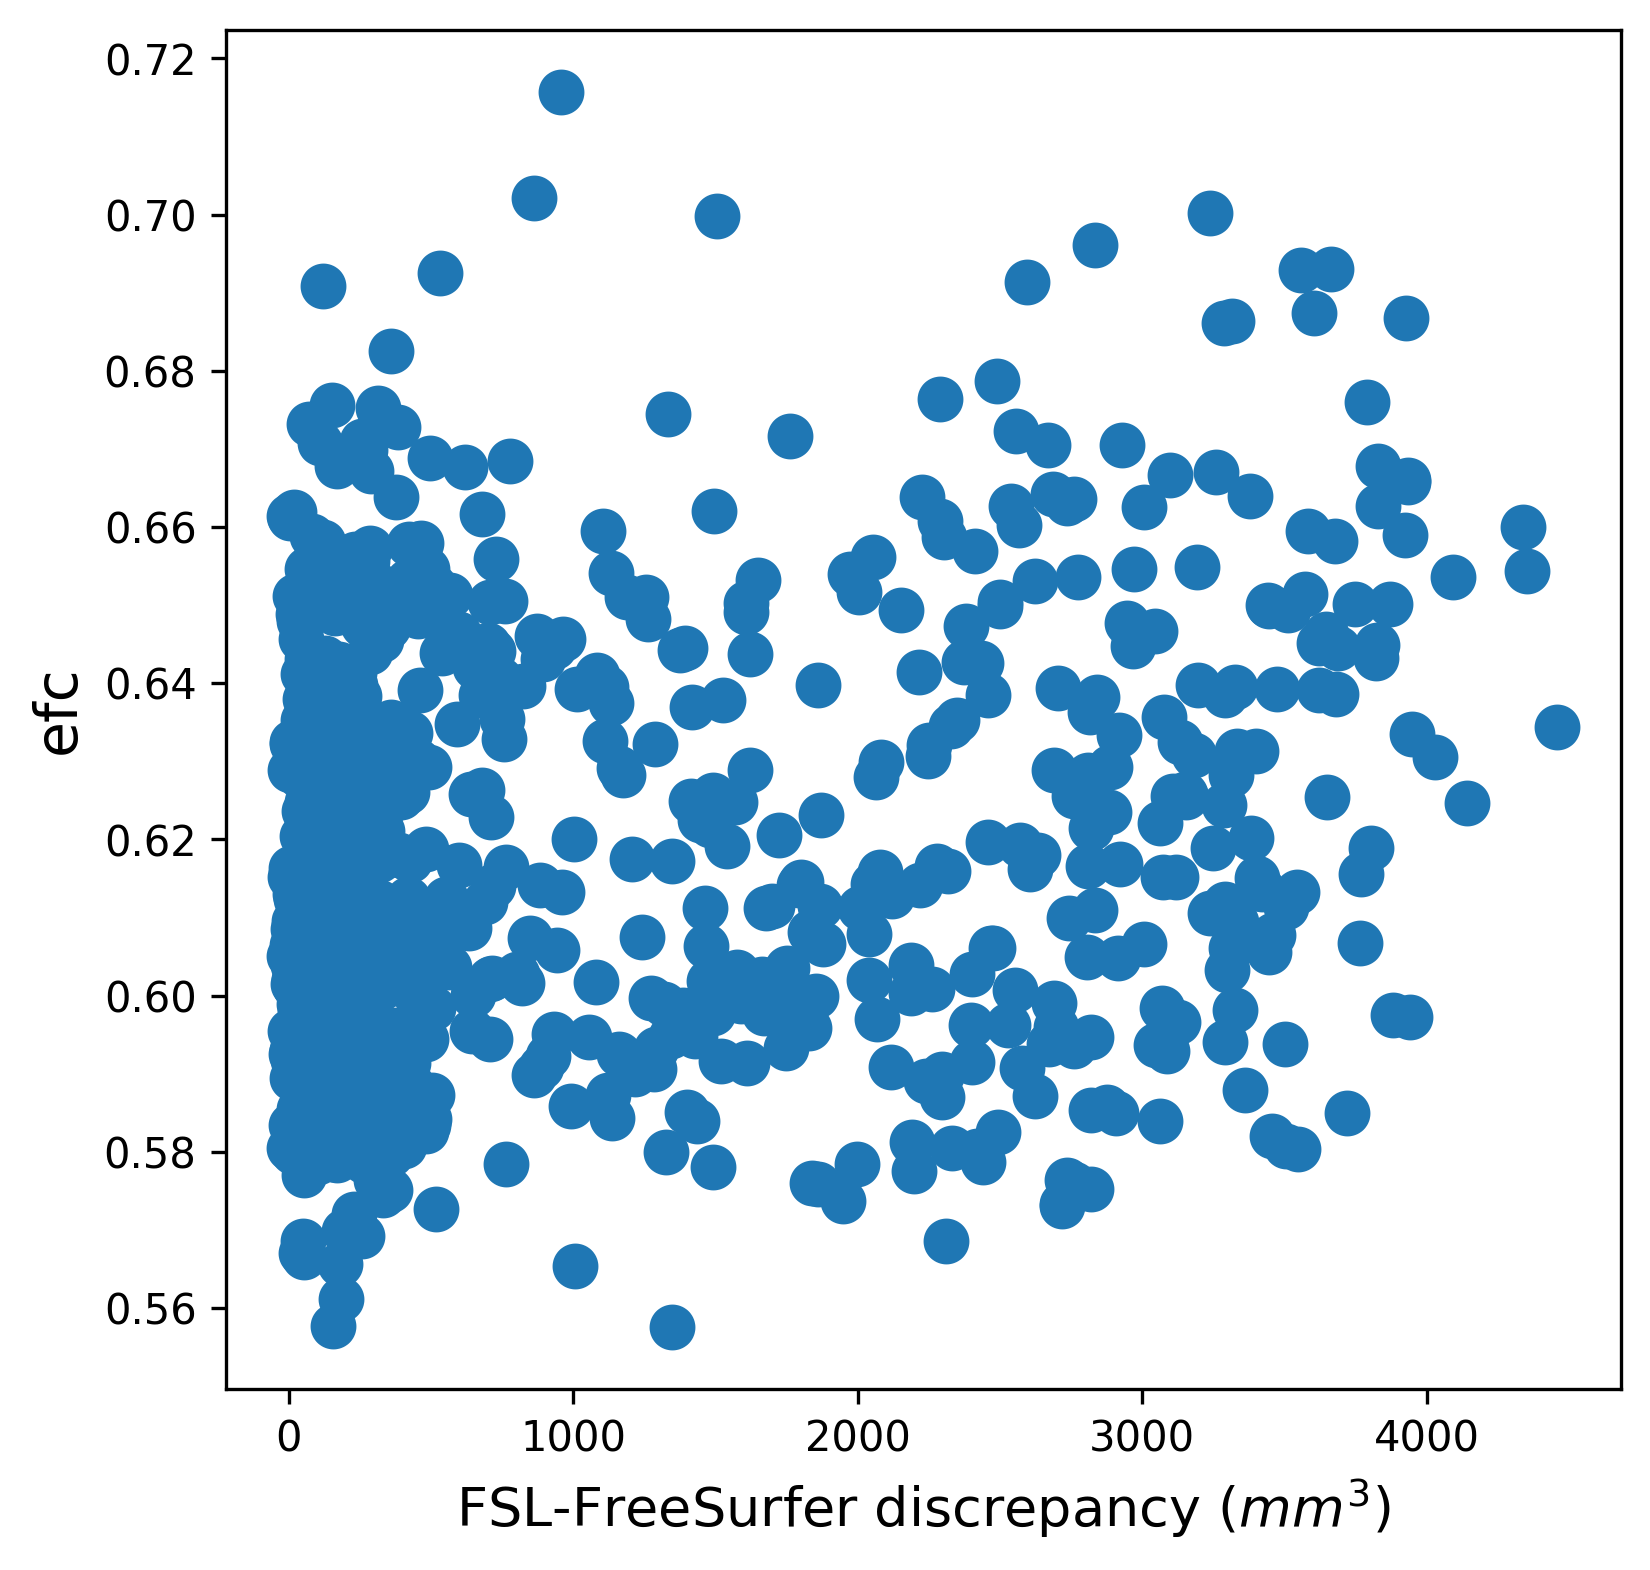

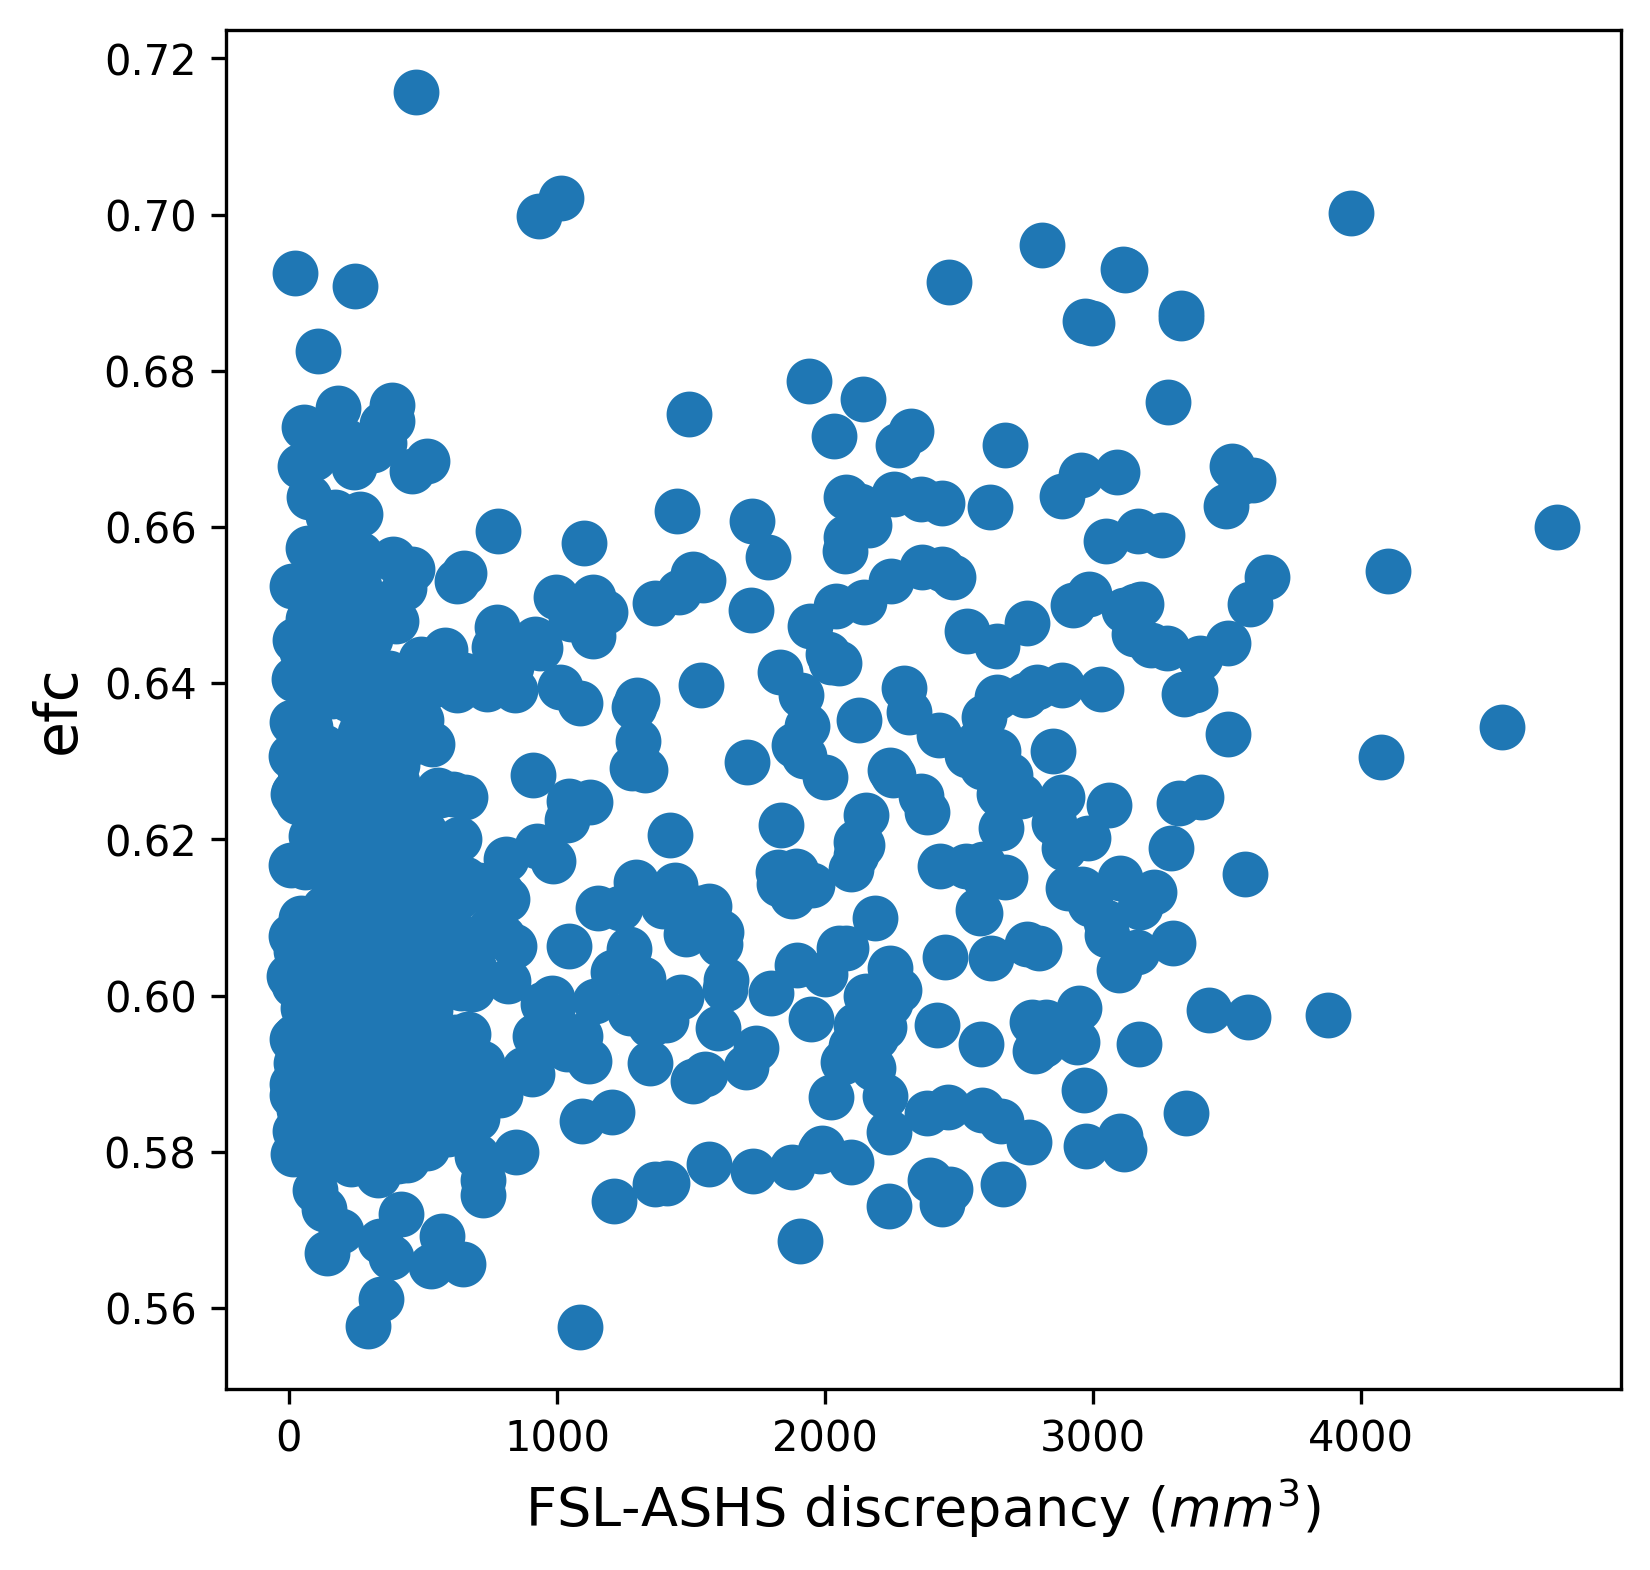

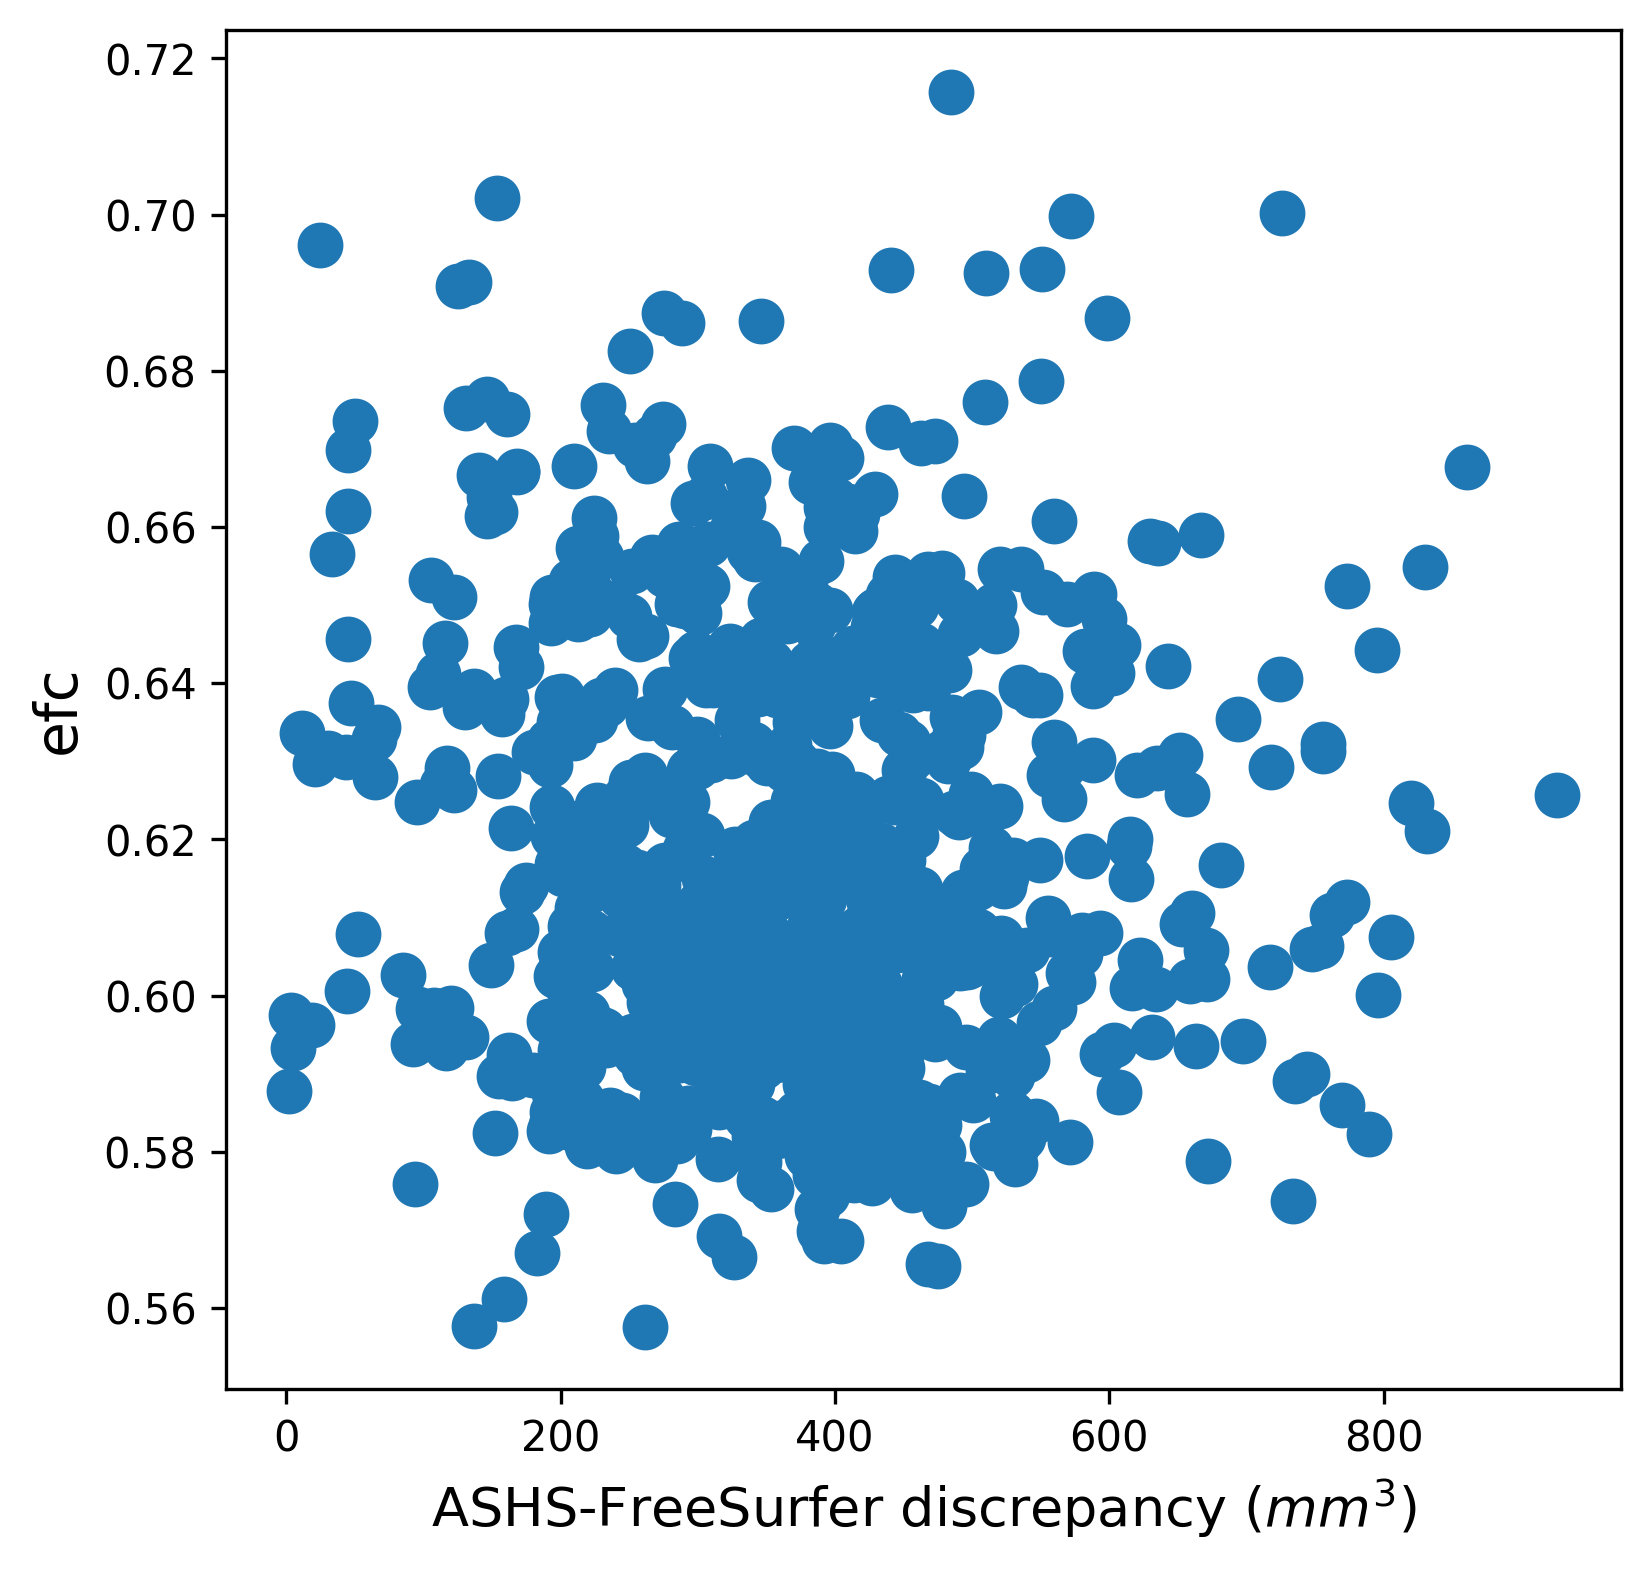

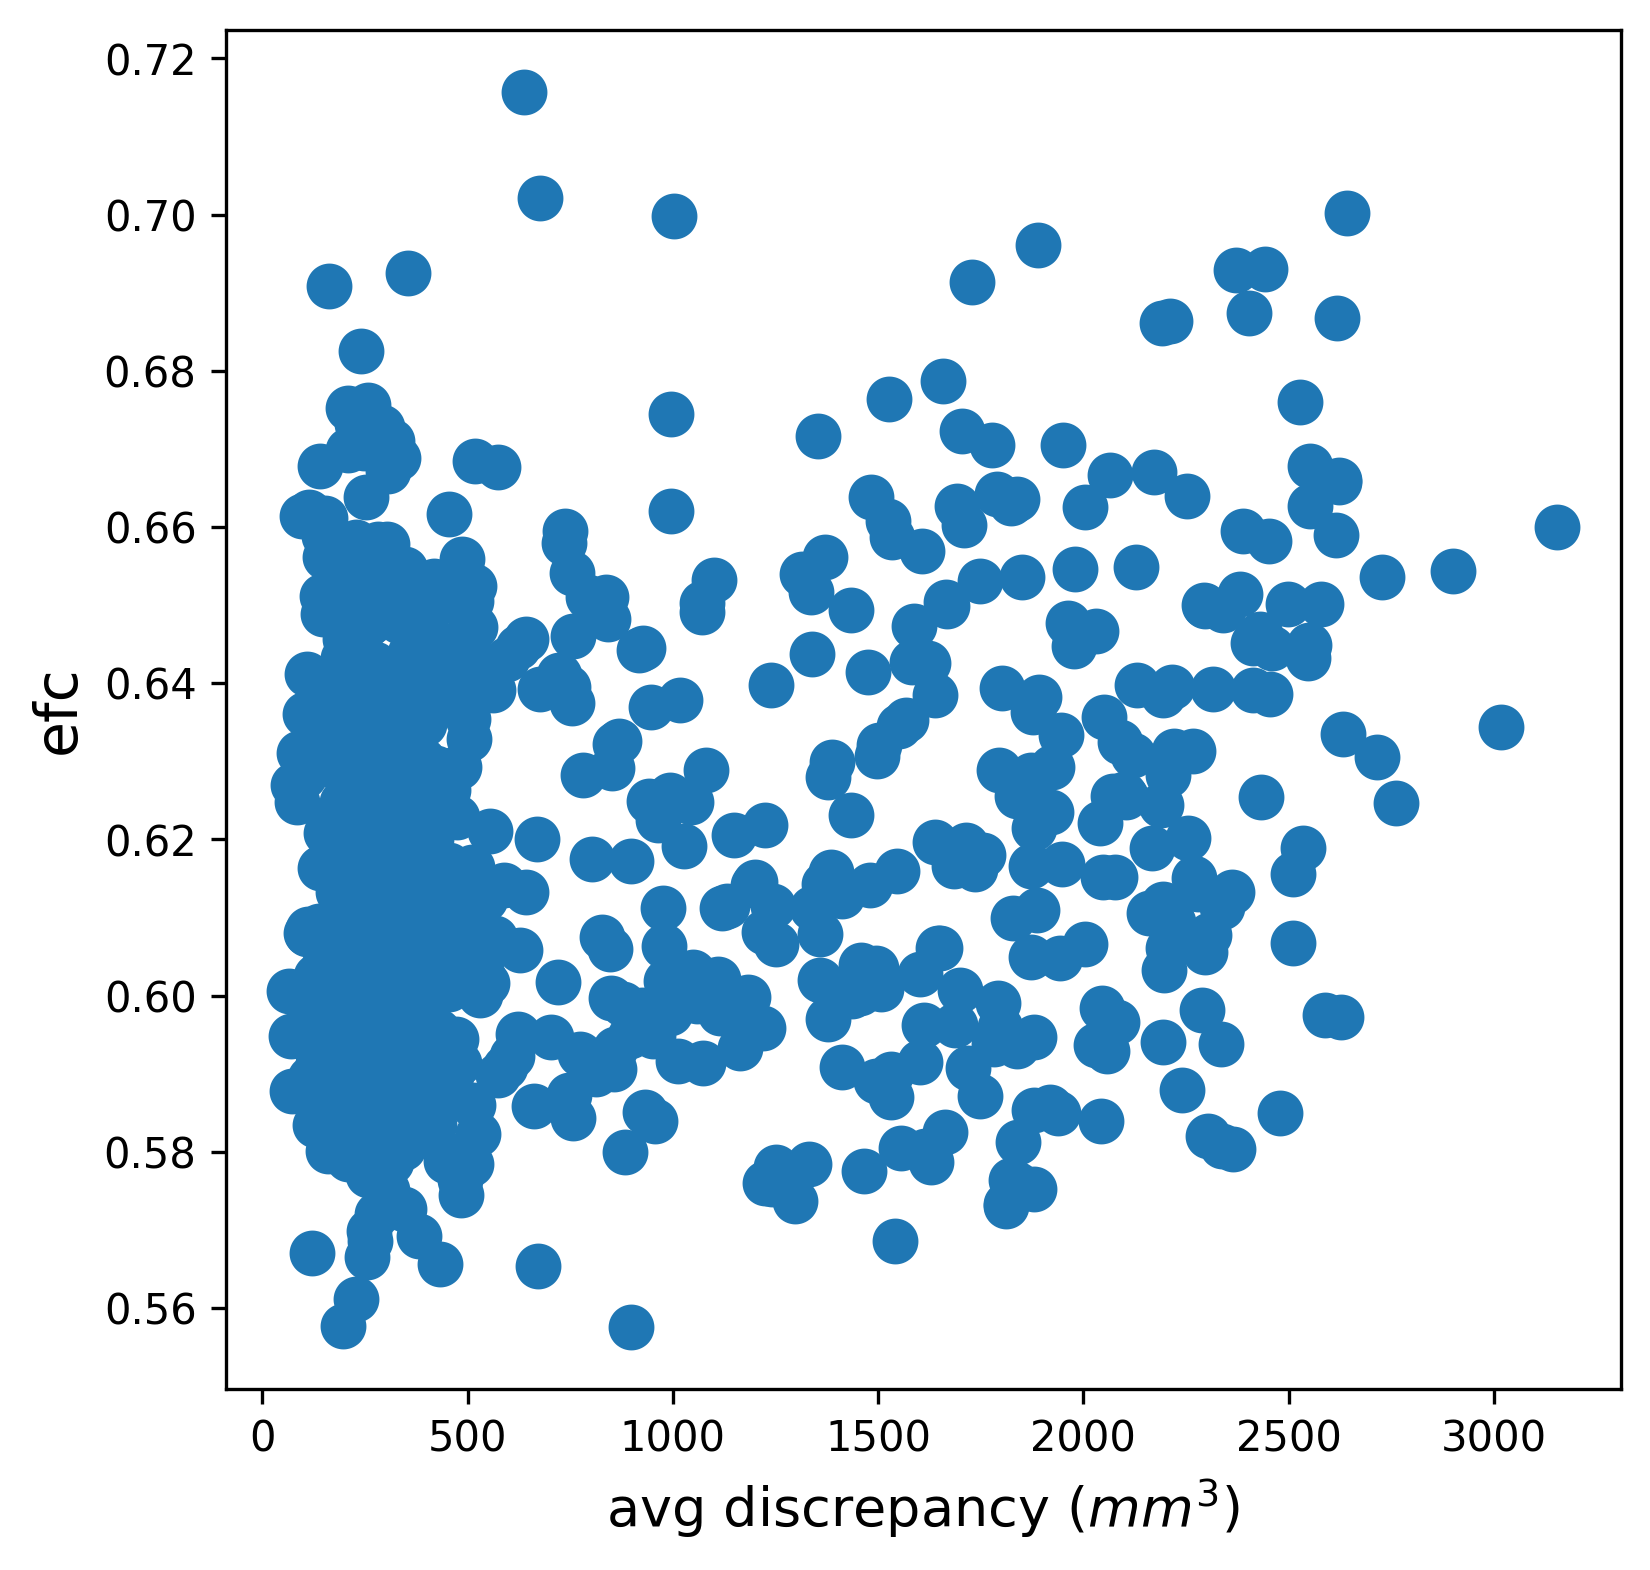

In [10]:
for discrepancy_key in target:

    corr_with_top_feature = np.corrcoef(target[discrepancy_key], observations[:, I])[0,1]

    # scatter plots

    plt.figure(figsize=(6, 6), dpi=300)
    plt.scatter( target[discrepancy_key], observations[:, I], label=top_feature, linewidth=5)
    plt.xlabel(discrepancy_key+' discrepancy ('+r'$mm^3$'+')', size=13)
    plt.ylabel(top_feature, size=14)
    plt.savefig(discrepancy_key+"-output-scatter.svg", transparent=True)
    # plt.show()

    # print correlation values of top correlated features
    print('*** correlation of the top feature -' + top_feature + '- with '+ discrepancy_key +' discrepancy = %.2f' %corr_with_top_feature)